### import packages

In [ ]:
import pandas as pd
import numpy as np
# miscellaneous 
import datetime
import os
import warnings
from functools import reduce
from enum import Enum
# GBM packages
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost as xgb
# scikit model pipeline and model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# visualisation tools
import seaborn as sns
import matplotlib.pyplot as plt
# shapley values for model inspection
import shap

# export requirements.txt
# pigar generate

### load data

In [66]:
df = pd.read_json("data.json")

In [67]:
df.head()

,target,customer_id,gender,transaction_vol,onboarding_date,balance,initial_payment,num_support_cases,acquisition_channel,lat_lon,age
0,0,142210,female,292.81,1636156800000,4732.101,308,0,chn_7296,"[41.3037839122, -81.9011725312]",19
1,0,61570,female,370.38,1600128000000,2481.931,1114,0,chn_7504,"[37.62783624, -116.8522755254]",35
2,0,99785,female,257.88,1661126400000,7990.572,722,0,chn_9611,"[37.6248201075, -116.8549549976]",21
3,0,92030,male,242.58,1614384000000,699.345,1407,0,chn_5397,"[27.3798979163, 33.6335197434]",87
4,0,57256,male,145.58,1623974400000,3545.378,2739,0,chn_9951,"[33.7485537211, -112.6332862735]",58


### data overview

In [68]:
df.shape

(92000, 11)

In [69]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92000 entries, 0 to 91999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   target               92000 non-null  int64  
 1   customer_id          92000 non-null  int64  
 2   gender               92000 non-null  object 
 3   transaction_vol      92000 non-null  float64
 4   onboarding_date      92000 non-null  int64  
 5   balance              92000 non-null  float64
 6   initial_payment      92000 non-null  int64  
 7   num_support_cases    92000 non-null  object 
 8   acquisition_channel  92000 non-null  object 
 9   lat_lon              92000 non-null  object 
 10  age                  92000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 8.4+ MB


what is lat_lon? latitude , longitude ... location of customer. 
lat_lon may be far too granular if stored as object. Consider splitting into two float features.

In [70]:
# split lat_lon into longitude and latitude
df[["latitude", "longitude"]] = df['lat_lon'].apply(pd.Series)

In [71]:
# remove lat_lon features
features_exclude = ['lat_lon']
df = df.drop(['lat_lon'], axis=1)

In [75]:
# Descriptive Stats
df.describe()

,target,customer_id,transaction_vol,onboarding_date,balance,initial_payment,age,latitude,longitude
count,92000.000000,92000.000000,92000.000000,9.200000e+04,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000
mean,0.081957,107220.325902,147.148267,1.626195e+12,3687.675326,1396.308935,45.739337,38.411064,-55.261930
std,0.274300,29449.230668,108.271536,2.786390e+10,5056.098757,1016.799970,21.099186,8.188900,61.164301
min,0.000000,56222.000000,0.010000,1.577837e+12,0.000000,0.000000,-1.000000,27.378421,-116.855345
25%,0.000000,81690.750000,60.560000,1.602115e+12,403.756000,580.000000,30.000000,33.742914,-112.635226
50%,0.000000,107209.500000,126.450000,1.626221e+12,1753.396000,1206.000000,43.000000,37.627649,-81.901683
75%,0.000000,132717.250000,212.360000,1.650326e+12,4957.483250,2020.000000,55.000000,41.304171,-0.554061
max,1.000000,158221.000000,759.570000,1.674173e+12,68800.363000,7372.000000,119.000000,51.849155,33.634282


# EDA

### missing values

In [54]:
pd.isnull(df).sum(axis=0).sort_values(ascending=False)[0:]

target                 0
customer_id            0
gender                 0
transaction_vol        0
onboarding_date        0
balance                0
initial_payment        0
num_support_cases      0
acquisition_channel    0
age                    0
latitude               0
longitude              0
dtype: int64

No missing values. Brilliant!

### duplicate data entries

In [55]:
df[df.duplicated()]

,target,customer_id,gender,transaction_vol,onboarding_date,balance,initial_payment,num_support_cases,acquisition_channel,age,latitude,longitude


no duplicates!

### create feature lists

In [115]:
target = "target"
# save numeric columns to list
numeric_features = list(df.select_dtypes(include=[np.number]).columns)
numeric_features = [x for x in numeric_features if x != numeric_features]
# save categorical columns to list
categorical_features = list(df.select_dtypes(['object']).columns)
categorical_features = [x for x in categorical_features if x != target]

### Distribution Analysis (outlier analysis included)

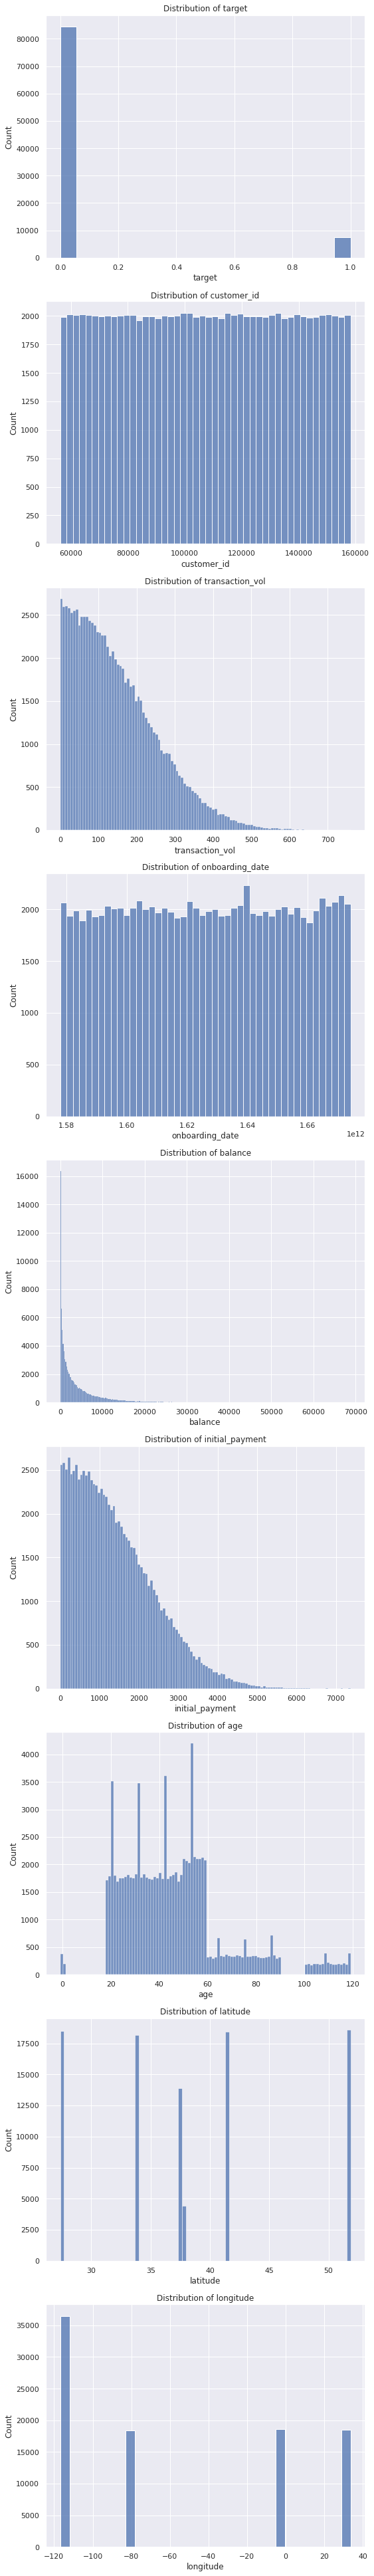

In [57]:
# histgrams numerical features
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 6 * len(numeric_features)))
for i, column in enumerate(numeric_features):
   sns.histplot(df[column], ax=axes[i])
   axes[i].set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

### findings
- age: some zero year old customers; this is an error; observations could be dropped or replaced with mean/median. I choose to replace with meadian. This is the most neutral value and will allow predictions to be made if this error occurs in fututre
- customer id: shows very flat distribution - to be expected; remove from model features
- balnce: very skew distribution, to be expected (distribution of wealth is skew)

In [61]:
df[df["age"]<5]["age"]

,target,customer_id,gender,transaction_vol,onboarding_date,balance,initial_payment,num_support_cases,acquisition_channel,age,latitude,longitude
311,0,115991,male,17.13,1625616000000,2246.827,1829,0,chn_14418,0,27.381662,33.632691
448,0,68589,male,238.61,1607990400000,9967.995,1973,1-2,chn_12962,0,41.303313,-81.901815
938,0,140038,male,185.98,1594771200000,3265.799,1895,0,chn_8995,0,27.380105,33.632534
956,0,110004,female,255.66,1647129600000,3464.909,852,0,chn_12181,-1,41.303851,-81.902305
990,0,150438,female,304.56,1579996800000,913.378,264,0,chn_5945,-1,27.378500,33.631047
...,...,...,...,...,...,...,...,...,...,...,...,...
91146,0,111472,male,2.49,1638144000000,16440.586,618,0,chn_15636,1,37.627220,-116.848302
91173,0,78815,female,297.44,1645660800000,6801.325,1267,5+,chn_15537,-1,37.625573,-116.849879
91411,0,132240,male,95.48,1593734400000,23.256,936,3-5,chn_1533,1,51.848538,-0.554377
91441,0,70422,female,236.82,1647129600000,357.680,1063,3-5,chn_14572,1,37.633534,-116.848562


In [76]:
# calcualte median age
median_age = np.median(df[df["age"]>5]["age"])
median_age

43.0

In [77]:
# replace ages below 18 with median age
df.loc[df['age'] < 18, 'age'] = median_age

In [78]:
# update exclude feature list
features_exclude = features_exclude + ["customer_id"]
features_exclude

['lat_lon', 'customer_id']

In [79]:
categorical_features

['gender', 'num_support_cases', 'acquisition_channel']

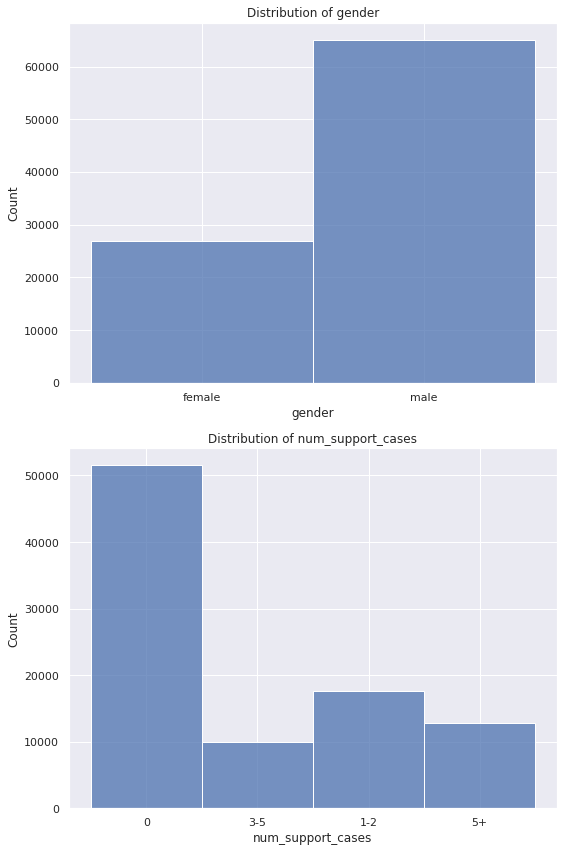

In [81]:
# countplots categorical features
categorical_features_tmp = ['gender', 'num_support_cases']
fig, axes = plt.subplots(nrows=len(categorical_features_tmp), ncols=1, figsize=(8, 6 * len(categorical_features_tmp)))
for i, column in enumerate(categorical_features_tmp):
   sns.histplot(df[column], ax=axes[i])
   axes[i].set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

### findings
- number of support cases: should be ordinal
- gender may ethically have to be removed?! let's remoe gender, it's 2023
- aquisition channel seems to far too many categories, small categories with be mapped to other

In [110]:
# make number of support cases ordinal
df.loc[df['num_support_cases'] == "0", 'num_support_cases'] = 0.
df.loc[df['num_support_cases'] == "1-2", 'num_support_cases'] = 1.
df.loc[df['num_support_cases'] == "3-5", 'num_support_cases'] = 2.
df.loc[df['num_support_cases'] == "5+", 'num_support_cases'] = 3.
df["num_support_cases"] = df["num_support_cases"].astype(int)

In [211]:
# Calculate value counts of each category 
value_counts = df['acquisition_channel'].value_counts()
value_counts.head(20)

other        57524
chn_6781      2520
chn_15537     2205
chn_9703      1634
chn_6648      1626
chn_11781     1521
chn_1279      1512
chn_12491     1257
chn_3566      1078
chn_11810     1025
chn_1857      1024
chn_9033       845
chn_8743       778
chn_11978      593
chn_4930       590
chn_10962      552
chn_2338       523
chn_14572      465
chn_14836      459
chn_2743       423
Name: acquisition_channel, dtype: int64

In [104]:
# Define the threshold for categories with few observations , this is somewhat arbitrary and would ideally be analyzed more 
threshold = 100

# Calculate value counts of each category 
value_counts = df['acquisition_channel'].value_counts()

# Identify categories with fewer observations than the threshold 
categories_to_map = value_counts[value_counts < threshold].index.tolist()

# Find the most frequent category
#most_frequent_category = value_counts.idxmax()

# Map categories with few observations to the most frequent category 
df.loc[df['acquisition_channel'].isin(categories_to_map), 'acquisition_channel'] = "other"


<AxesSubplot:xlabel='acquisition_channel', ylabel='count'>

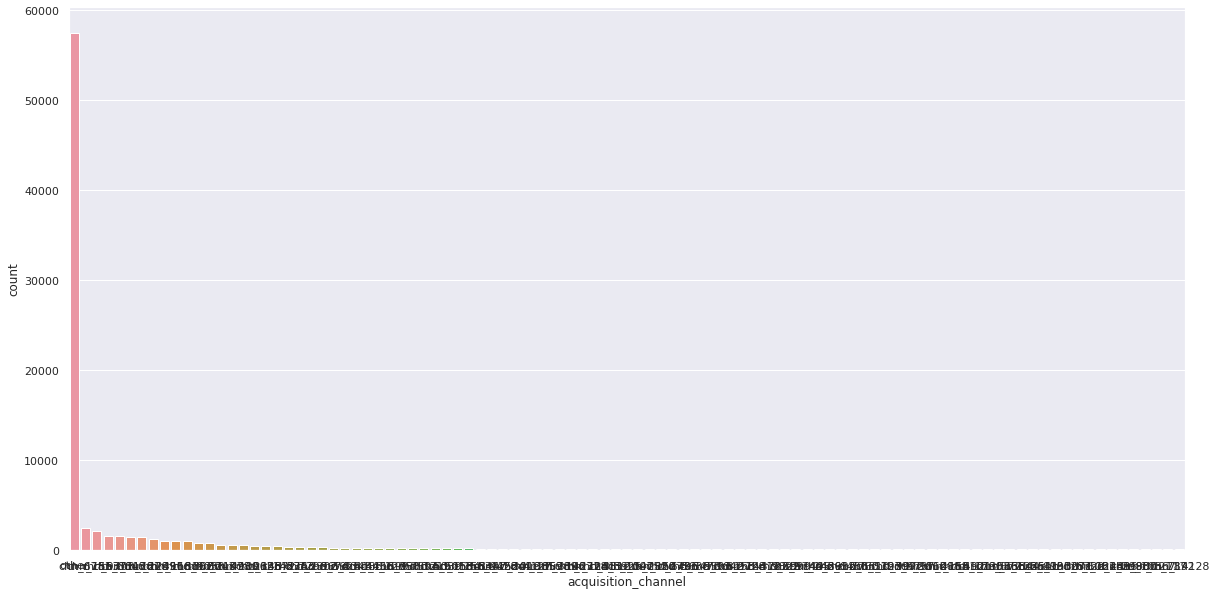

In [105]:
# Count the number of categories in the 'acquisition_channel' column
category_counts = df['acquisition_channel'].value_counts()

# Create a bar plot to visualize the distribution
sns.countplot(x='acquisition_channel', data=df, order=category_counts.index)

In [111]:
# exclude further features because they're constant
features_exclude = features_exclude + ["gender"]
features_exclude

['lat_lon', 'customer_id', 'gender']

## Relationship to target variable

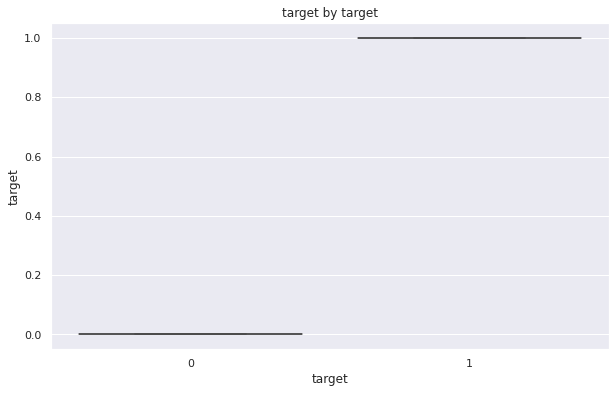

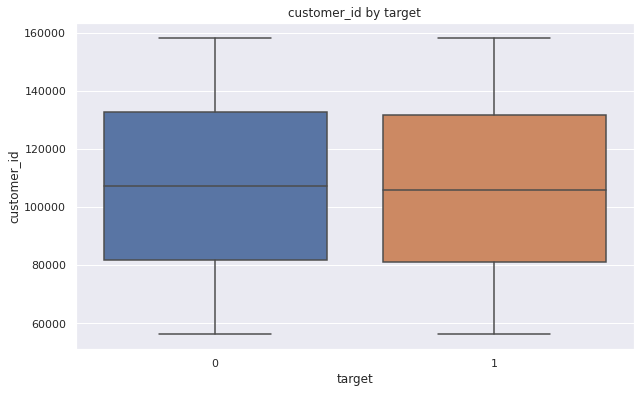

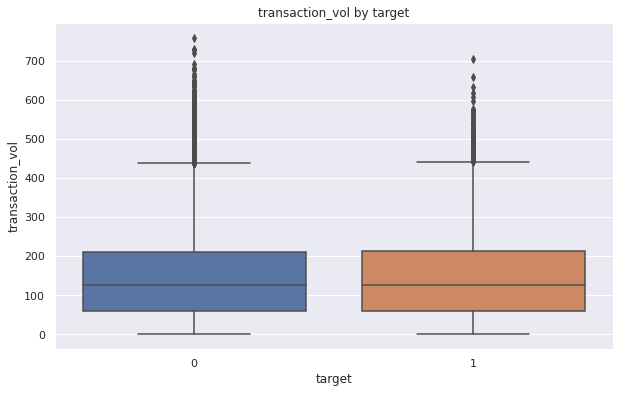

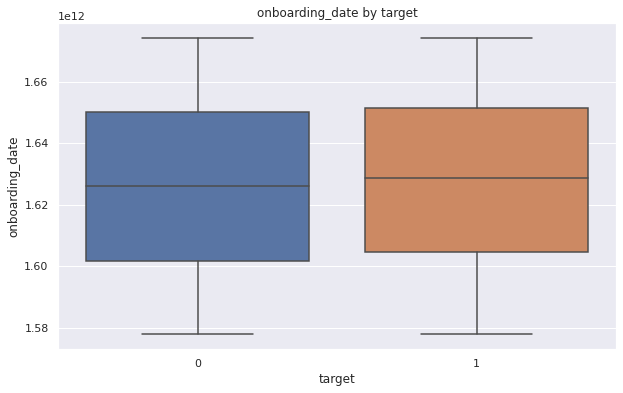

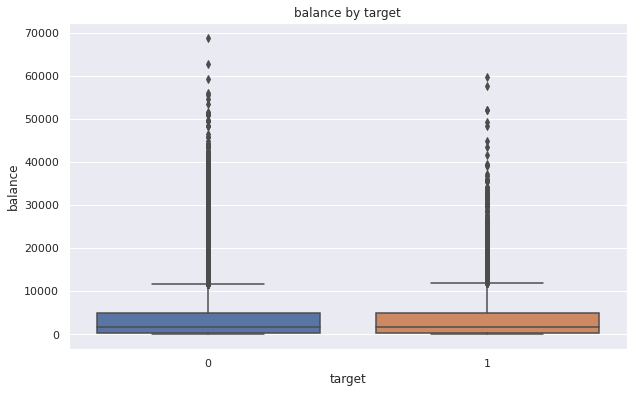

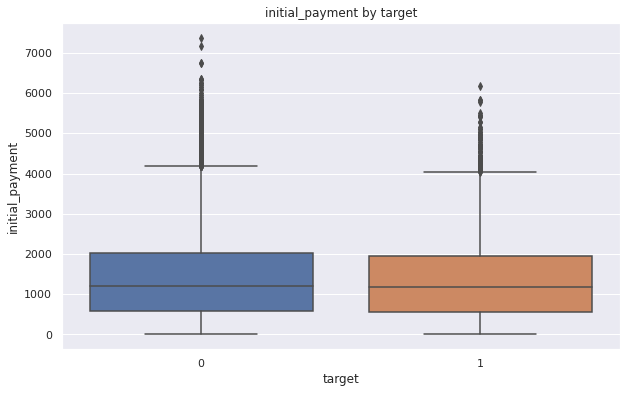

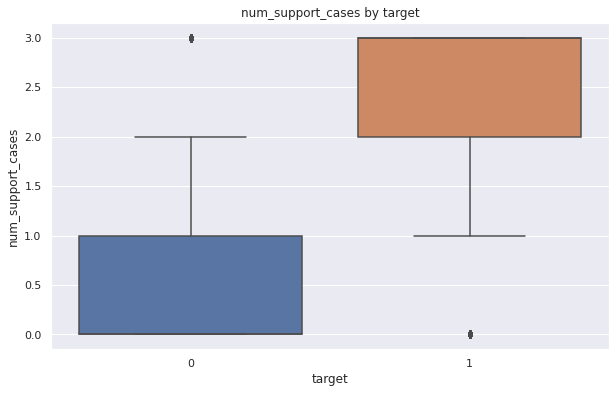

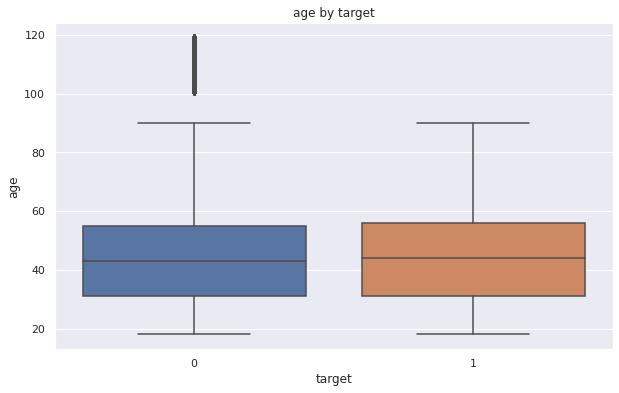

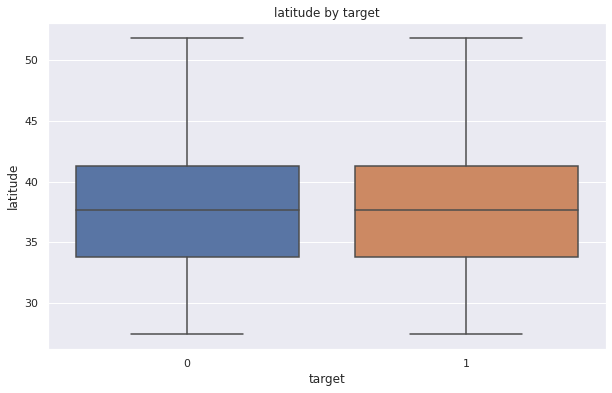

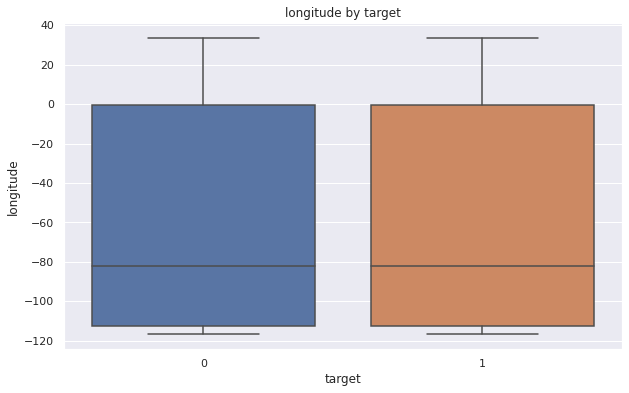

In [116]:
# Box plots of numerical features for categories target variable
for column in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=target, y=column)
    plt.title(f"{column} by {target}")
    plt.xlabel(target)
    plt.ylabel(column)
    plt.show()

In [126]:
df_tmp = df.groupby('acquisition_channel').agg({target: ['mean', 'sum', 'std', 'count']})
#df_tmp.sort_values(['mean'],ascending=False)
df_tmp

target                     
                        mean sum       std  count
acquisition_channel                              
chn_10367            0.00000   0  0.000000    106
chn_1091             0.00000   0  0.000000    193
chn_10962            0.01087   6  0.103783    552
chn_11068            0.00000   0  0.000000    130
chn_11699            0.00000   0  0.000000    286
...                      ...  ..       ...    ...
chn_9737             0.00000   0  0.000000    132
chn_9744             0.00000   0  0.000000    147
chn_9822             0.00000   0  0.000000    150
chn_9972             0.00000   0  0.000000    136
other                0.00000   0  0.000000  57524

[99 rows x 4 columns]

### findings
- number of support case is strong
- transactional volume and balance may also be strong in their end range
- aquisition channel may need to be dropped. I dont know exactly what it mean. It could be informative but could also lead to overfitting

## Correlation btw. numerical features

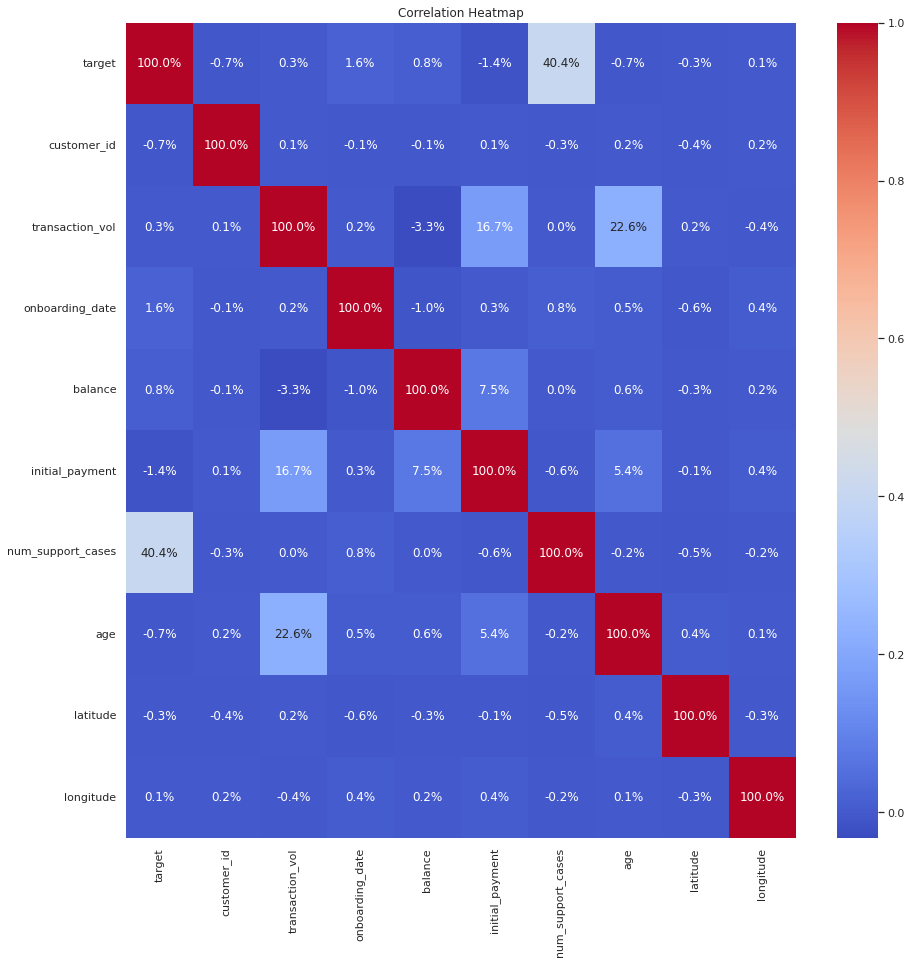

In [117]:
# plain pearson correlation
plt.figure(figsize = (15, 15))
sns.set(font_scale = 1)
sns.heatmap(df.corr(method= "pearson"), annot=True, cmap='coolwarm', fmt=".1%")
plt.title('Correlation Heatmap')
plt.show()

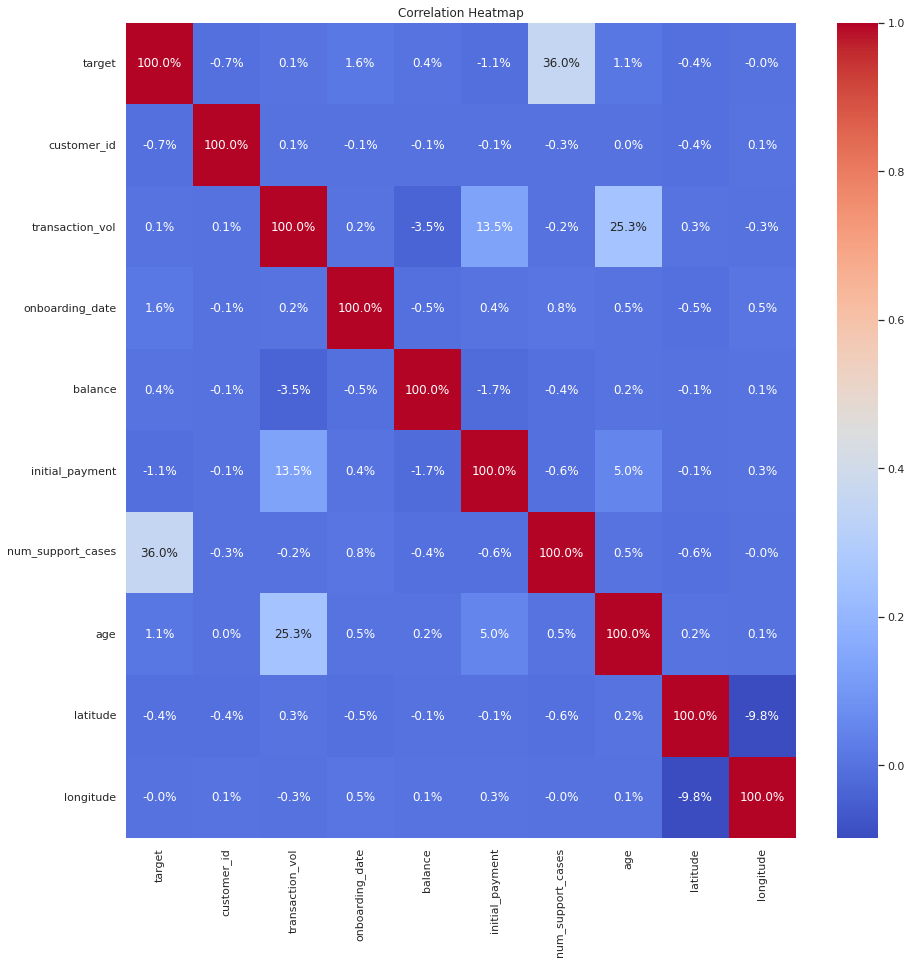

In [118]:
# spearman correlation for non-linear interaction analysis
# method{‘pearson’, ‘kendall’, ‘spearman’
plt.figure(figsize = (15, 15))
sns.set(font_scale = 1)
sns.heatmap(df.corr(method= "spearman"), annot=True, cmap='coolwarm', fmt=".1%")
plt.title('Correlation Heatmap')
plt.show()

### findings 
fairly low correlation

## Basic Preprocessing

In [127]:
# gather preprocessing steps from above

In [180]:
def basic_data_preprocessing(file_path, target): 
    # read data
    df = pd.read_json(file_path)
    
    # split lat_lon into longitude and latitude
    df[["latitude", "longitude"]] = df['lat_lon'].apply(pd.Series)
    
    # replace ages below 18 with median age
    df.loc[df['age'] < 18, 'age'] = 43
    
    # make number of support cases ordinal
    df.loc[df['num_support_cases'] == "0", 'num_support_cases'] = 0.
    df.loc[df['num_support_cases'] == "1-2", 'num_support_cases'] = 1.
    df.loc[df['num_support_cases'] == "3-5", 'num_support_cases'] = 2.
    df.loc[df['num_support_cases'] == "5+", 'num_support_cases'] = 3.
    df["num_support_cases"] = df["num_support_cases"].astype(int)
    
    # Calculate value counts of each category 
    value_counts = df['acquisition_channel'].value_counts()

    # Identify categories with fewer observations than the threshold 
    categories_to_map = value_counts[value_counts < 100].index.tolist()

    # Find the most frequent category
    #most_frequent_category = value_counts.idxmax()

    # Map categories with few observations to the most frequent category 
    df.loc[df['acquisition_channel'].isin(categories_to_map), 'acquisition_channel'] = "other"
    
    # drop features  
    df = df.drop(['lat_lon', 'customer_id', 'gender'], axis=1)
    
    # save numeric columns to list
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    numeric_features = [x for x in numeric_features if x != target]
    # save categorical columns to list
    categorical_features = list(df.select_dtypes(['object']).columns)
    categorical_features = [x for x in categorical_features if x != target]
    
    return df, numeric_features, categorical_features

In [150]:
# read data anew and perform all preprocessing 
df, numeric_features, categorical_features = basic_data_preprocessing("data.json", target = "target") 

In [130]:
df.head()

,target,transaction_vol,onboarding_date,balance,initial_payment,num_support_cases,acquisition_channel,age,latitude,longitude
0,0,292.81,1636156800000,4732.101,308,0,chn_7296,19,41.303784,-81.901173
1,0,370.38,1600128000000,2481.931,1114,0,chn_7504,35,37.627836,-116.852276
2,0,257.88,1661126400000,7990.572,722,0,other,21,37.624820,-116.854955
3,0,242.58,1614384000000,699.345,1407,0,chn_5397,87,27.379898,33.633520
4,0,145.58,1623974400000,3545.378,2739,0,other,58,33.748554,-112.633286


In [151]:
numeric_features, categorical_features

(['transaction_vol',
  'onboarding_date',
  'balance',
  'initial_payment',
  'num_support_cases',
  'age',
  'latitude',
  'longitude'],
 ['acquisition_channel'])

# Model Selection

### create test and training samples

In [152]:
# create test and training sets
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

### build model pipeline

In [153]:
# missing values for numeric features are imputed with median value of respective feature
# values are standardized (actually normalized) -- not really necessary for tree based algorithms
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# missing values for categorical features are replaced with "missing" - allowing missng values to be informative (most_frequent replacement should be compared)
# categorical features are one-hot encoded (CatBoost can also handle categorical features)
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# putting the preprocessor together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Model selection (hyperparameter tuning) via random search 
- random search is more performative than grid search
- My go to model type for structured data is gradient boosting - highly performative, easy to tune and explainable with TreeShap

In [ ]:
# instantiate the pipeline with chosen model type
clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('model', CatBoostClassifier())])   #CatBoostClassifier(), LGBMClassifier()

# define parameter space to be searched
param_grid = {'model__depth':[3,4,5],
          'model__iterations':[200,300, 500],
          'model__learning_rate':[0.03,0.001,0.01], 
          'model__l2_leaf_reg':[3,1,5,10]}

# perform random search with cross-validation
# performance measure chosen is AUC 
grid_search = RandomizedSearchCV(clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train,y_train)

In [156]:
# Access the best set of parameters
best_params = grid_search.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid_search.best_estimator_
print(best_pipe)

{'model__learning_rate': 0.03, 'model__l2_leaf_reg': 3, 'model__iterations': 500, 'model__depth': 5}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['transaction_vol',
                                                   'onboarding_date', 'balance',
                                                   'initial_payment',
                                                   'num_support_cases', 'age',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                          

validate result on test sample

In [157]:
print('Training set score: ' + str(grid_search.score(X_train, y_train)))
print('Test set score: ' + str(grid_search.score(X_test, y_test)))

Training set score: 0.9850315509848273
Test set score: 0.9816748882383493


Very high AUC metric. Model also looks stable on test sample. Hence, I choose not to tune depth and iterations further.

In [159]:
#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(best_pipe['model'])

#apply the preprocessing to x_test
observations = best_pipe['preprocessor'].transform(X_test)

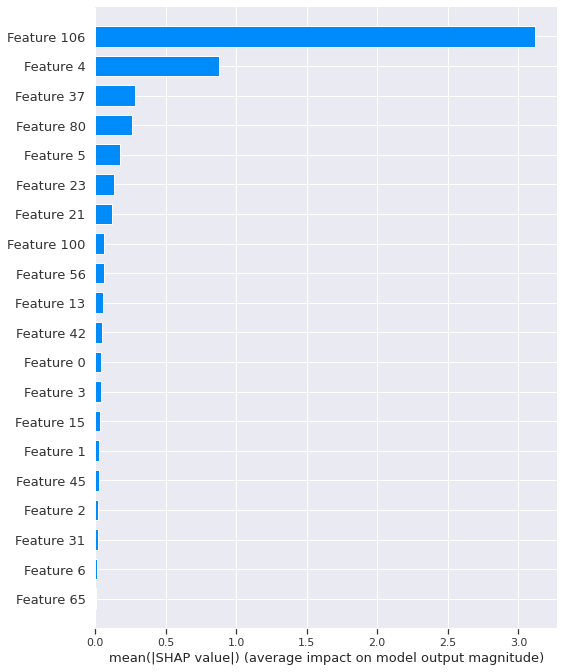

In [160]:
#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, observations, plot_type="bar")

# Build Interpretable model (without feature encoding)

### Use the optimized hyperparameters from previous step and build a more interpretable model without one-hot encoding
- also keep only top 10 aquisition channels

In [240]:
def basic_data_preprocessing(file_path, target): 
    # read data
    df = pd.read_json(file_path)
    
    # split lat_lon into longitude and latitude
    df[["latitude", "longitude"]] = df['lat_lon'].apply(pd.Series)
    
    # replace ages below 18 with median age
    df.loc[df['age'] < 18, 'age'] = 43
    
    # make number of support cases ordinal
    df.loc[df['num_support_cases'] == "0", 'num_support_cases'] = 0.
    df.loc[df['num_support_cases'] == "1-2", 'num_support_cases'] = 1.
    df.loc[df['num_support_cases'] == "3-5", 'num_support_cases'] = 2.
    df.loc[df['num_support_cases'] == "5+", 'num_support_cases'] = 3.
    df["num_support_cases"] = df["num_support_cases"].astype(int)

    # Map the less frequent categories to 'Other'
    top_10_channels = ["chn_6781", "chn_15537", "chn_9703", "chn_6648", "chn_11781", "chn_1279", "chn_12491", "chn_3566", "chn_11810", "chn_1857"]
    df['acquisition_channel'] = df['acquisition_channel'].apply(lambda x: x if x in top_10_channels else 'Other')
    
    # drop features  
    df = df.drop(['lat_lon', 'customer_id', 'gender'], axis=1)
    
    # save numeric columns to list
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    numeric_features = [x for x in numeric_features if x != target]
    # save categorical columns to list
    categorical_features = list(df.select_dtypes(['object']).columns)
    categorical_features = [x for x in categorical_features if x != target]
    
    return df, numeric_features, categorical_features

In [241]:
# read data anew and perform all preprocessing 
df, numeric_features, categorical_features = basic_data_preprocessing("data.json", target = "target") 

# create test and training sets
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [219]:
#{'model__learning_rate': 0.03, 'model__l2_leaf_reg': 3, 'model__iterations': 500, 'model__depth': 5}
interpretable_model = CatBoostClassifier(iterations=500, learning_rate=0.03, l2_leaf_reg = 3, depth = 5, random_seed=42)

In [220]:
interpretable_model.fit(X_train,
          y_train,
          cat_features = categorical_features,
          eval_set = (X_test, y_test),
          use_best_model = True,
          verbose = False
         )

In [221]:
pred = interpretable_model.predict(X_train)
auc = (np.sqrt(roc_auc_score(y_train, pred)))
print("Performance on training sample")
print("AUC: {:.2f}".format(auc))

Performance on training sample
AUC: 0.92


In [222]:
pred = interpretable_model.predict(X_test)
auc = (np.sqrt(roc_auc_score(y_test, pred)))
print("Performance out of sample")
print("AUC: {:.2f}".format(auc))

Performance out of sample
AUC: 0.91


Anaylze where this performance comes from

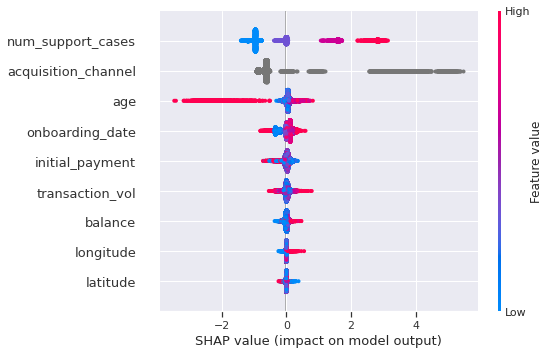

In [223]:
explainer = shap.TreeExplainer(interpretable_model)
shap_values = explainer.shap_values(X_test)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

# Build Final Model (with feature encoding)

In [245]:
# instantiate the pipeline with chosen model type
clf = Pipeline(steps=[('preprocessor', preprocessor),
                  ('model', CatBoostClassifier(iterations=500, learning_rate=0.03, l2_leaf_reg = 3, depth = 5, random_seed=42))])  

In [ ]:
clf.fit(X_train,y_train)

In [255]:
pred = clf.predict(X_train)
auc = (np.sqrt(roc_auc_score(y_train, pred)))
print("Performance on training sample")
print("AUC: {:.2f}".format(auc))

Performance on training sample
AUC: 0.92


In [256]:
pred = clf.predict(X_test)
auc = (np.sqrt(roc_auc_score(y_test, pred)))
print("Performance out of sample")
print("AUC: {:.2f}".format(auc))

Performance out of sample
AUC: 0.91


## Summary
The most important features are 
- acquisition channel
- num_support_cases
- age (strnge result: risk of churn does not directly correlate to age, older folks can be both high and low risk) -- to be analyzed
- and transaction_vol

This makes sense. BUt I'd like an expert opinion on the aquisition channel. Anyhow, aquisition_channel doesnt lead to overfitting 

I should have split the onboarding date into days, months hours but I'm out of time. 

# Predictions

In [247]:
test = pd.read_csv("test.csv")
template = pd.read_csv("submission_template.csv")

In [248]:
template.head()

,customer_id,y_pred
0,156446,NaN
1,148626,NaN
2,119200,NaN
3,104872,NaN
4,125830,NaN


In [249]:
test.head()

,customer_id,gender,transaction_vol,onboarding_date,balance,initial_payment,num_support_cases,acquisition_channel,lat_lon,age
0,156446,female,165.28,2022-12-13,437.036,2387.0,0,chn_1279,"(51.84792561391779, -0.5545511316992315)",19
1,148626,male,43.62,2021-09-02,35.369,2257.0,0,chn_1479,"(27.38174540167766, 33.63054230253046)",55
2,119200,male,198.90,2022-06-02,2492.551,1314.0,5+,chn_607,"(41.30427211061869, -81.90194567885146)",60
3,104872,female,155.72,2022-07-28,9766.774,611.0,0,chn_13939,"(27.379347074509358, 33.63299906529242)",26
4,125830,female,247.54,2022-02-20,5892.822,651.0,0,chn_412,"(41.303739985857604, -81.90139576173344)",46


In [250]:
def preprocessing_predicitons(file_path): 
    # read data
    df = pd.read_csv(file_path)
    
    #date to date integer 
    df["onboarding_date"] = pd.to_datetime(df["onboarding_date"])
    df["onboarding_date"] = df["onboarding_date"].astype(int)  
    # Define a function to extract values and convert to floats 
    def extract_values_and_convert_to_floats(s):
       s = s.replace('(', '').replace(')', '')  # Remove brackets
       values = s.split(', ')  # Split by comma and space
       return [float(x) for x in values]  # Convert to float list

    # Apply the function to the 'string_column' and create a new column 'float_column'
    df['lat_lon'] = df['lat_lon'].apply(extract_values_and_convert_to_floats)

    # split lat_lon into longitude and latitude
    df[["latitude", "longitude"]] = df['lat_lon'].apply(pd.Series)
    
    # replace ages below 18 with median age
    df.loc[df['age'] < 18, 'age'] = 43
    
    # make number of support cases ordinal
    df.loc[df['num_support_cases'] == "0", 'num_support_cases'] = 0.
    df.loc[df['num_support_cases'] == "1-2", 'num_support_cases'] = 1.
    df.loc[df['num_support_cases'] == "3-5", 'num_support_cases'] = 2.
    df.loc[df['num_support_cases'] == "5+", 'num_support_cases'] = 3.
    df["num_support_cases"] = df["num_support_cases"].astype(int)
    
    # Map the less frequent categories to 'Other'
    top_10_channels = ["chn_6781", "chn_15537", "chn_9703", "chn_6648", "chn_11781", "chn_1279", "chn_12491", "chn_3566", "chn_11810", "chn_1857"]
    df['acquisition_channel'] = df['acquisition_channel'].apply(lambda x: x if x in top_10_channels else 'Other')
    
    # drop features  
    df = df.drop(['lat_lon', 'customer_id', 'gender'], axis=1)
    
    return df

In [251]:
test_preprocessed = preprocessing_predicitons("test.csv")

In [252]:
test_preprocessed.head()

,transaction_vol,onboarding_date,balance,initial_payment,num_support_cases,acquisition_channel,age,latitude,longitude
0,165.28,1670889600000000000,437.036,2387.0,0,chn_1279,19,51.847926,-0.554551
1,43.62,1630540800000000000,35.369,2257.0,0,Other,55,27.381745,33.630542
2,198.90,1654128000000000000,2492.551,1314.0,3,Other,60,41.304272,-81.901946
3,155.72,1658966400000000000,9766.774,611.0,0,Other,26,27.379347,33.632999
4,247.54,1645315200000000000,5892.822,651.0,0,Other,46,41.303740,-81.901396


### make predictions

In [253]:
predicitons = clf.predict(test_preprocessed)

In [268]:
output = pd.DataFrame(test["customer_id"])

In [264]:
test_preprocessed.shape

(10000, 9)

In [269]:
output["y_pred"] = predicitons

In [272]:
output["y_pred"].sum()

640

In [274]:
output.to_csv("submission_alexander_mendelsohn.csv", encoding='utf-8', index=False)